#Bryan Camilo Hurtado Suarez

### Data analyst/ Data scientist

###Contact information:

* cel: +57 3228412057
* email: bcamilo.hurtado@hotmail.com
* Linkedln: https://www.linkedin.com/in/bryancamilohurtado-dataanalyst/

#Context:

Mental health has become a key factor on the modern world, due to the raise in mental illness. One of it that most affect the people is depression, a delicate situation that need treatment and the guidance of an expert such a therapist or psychology, studies of the  World Health Organization state that more than 700,000 people committed suicide during the year 2022. For every suicide, there are likely 20 other people making a suicide attempt and many more have serious thoughts of suicide.




#Objective:

The objective of this project is create a tool which function is being a support to experts on mental health. Then, this model would be able to detect statements or commentaries that are related with suicide behavior, and then inform to the experts that would initiate a process to guide this person.

#Dataset:

The dataset is a collection of posts from the "SuicideWatch" and "depression" subreddits of the Reddit platform. The posts are collected using Pushshift API. All posts that were made to "SuicideWatch" from Dec 16, 2008(creation) till Jan 2, 2021, were collected while "depression" posts were collected from Jan 1, 2009, to Jan 2, 2021. All posts collected from SuicideWatch are labeled as suicide, While posts collected from the depression subreddit are labeled as depression. Non-suicide posts are collected from r/teenagers.

Version:
The current version has only suicide & non-suicide labels.

First, It's neccesary to install the different libraries that would be used on the project:

In [ ]:
!pip install neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 2.9 MB/s eta 0:00:00


Then, import the libraries:

In [ ]:
# data handle libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import plotly.express as plx
import seaborn as sns

# machine learning libraries
import sklearn
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.layers import Dense,LSTM,GlobalMaxPooling1D,Input,Embedding
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

#text libraries
from tqdm import tqdm
import neattext.functions as nfx
from wordcloud import WordCloud



Next, load the data into a pandas dataframe:

In [ ]:
df = pd.read_csv('/content/Suicide_Detection.csv') #read de cvs archive
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [ ]:
df = df[['text','class']]

##Methodology:




* Initial exploration
* Data cleaning
* Analysis
* Model

###Initial exploration:

It's important to know all of the dataset's columns and the type of each one:

In [ ]:
df.columns

Index(['text', 'class'], dtype='object')

In [ ]:
df.dtypes

text     object
class    object
dtype: object

Examples of commentaries, for each case( non-suicide and suicide):

In [ ]:
print("Non-suicide samples:")
for t in df[df["class"] == "non-suicide"].sample(5)["text"].tolist():
    print("--")
    print(t)
print("=============================================\n\n")
print("Suicide samples:")
for t in df[df["class"] == "suicide"].sample(5)["text"].tolist():
    print("--")
    print(t)

Non-suicide samples:
--
Guess my favourite dinosaur and you will get a free silver award Bonus: tell me your favourite one and i will get a slight release from this eternal agony when my thalamus decides that the notification i get from your comments counts as an achievement and gives me some of that sweet sweet dopamine i have been craving for ages...

Anyways i only have 1 award so only the first right guess gets it!
--
I took a nap and now my parents think that I do drugs The situation:
Yesterday I got to bed too late and slept for like ~5 hours. Today when I got home from school, I immediately got to bed and fell asleep. When I woke up it was evening. Parents took me to kitchen and we sat to talk. Uh. They started to accuse me for doing drugs. I was shocked. I had nothing to say. They took my phone and started to read my PMs. Then we went to my room and started to look over my stuff. They found a pen case and said that i could use it for sniffing drugs. I don't even know why I didn

In [ ]:
df.shape

(232074, 2)

We can observe that the quantity of records is 232074, and two columns that we apreciated in past steps

####Look for missing data

It's important to understand if the the data is complete. In the contrary, we will take care of handle the missing values with some techniques

In [ ]:
df.isna().sum()

text     0
class    0
dtype: int64

The outcome is that there aren't missing values within the dataset

####Categorical values:

In [ ]:
df['class'].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

it could be observed that the data is in balance, this would be helpfull at the time of building de machine learning model.

Now, with the objettive of have a better understanding of it a visualization is create:

In [ ]:
plx.bar(df,x=df['class'].value_counts().index.values,
        y=df['class'].value_counts(),color=['Suicide','Not Suicide'])

###Data cleaning

First, It's neccesary to split the dataset, a part for the training of the model and another one for the test process (20% test, 80% train):

In [ ]:
train_data,test_data=train_test_split(df,test_size=0.2,random_state=10)

In [ ]:
train_data['class'].value_counts()

suicide        92831
non-suicide    92828
Name: class, dtype: int64

In [ ]:
test_data['class'].value_counts()

non-suicide    23209
suicide        23206
Name: class, dtype: int64

We can observe the balance between the two classes in each dataset

Now, We must clean the text with the objetive to properly clean the model. Additionally, it's important to calculate lenght of each example for analysis and the model training

In [ ]:
# a funtion that cleand the text: lower it, remove especial characters and stop words such "is", "and", "the"...
# and calculate the lenght of the text
def clean_text(text):
    # text: an array which every statement
    text_length=[]
    cleaned_text=[]
    for txt in tqdm(text):
        txt=txt.lower()
        txt=nfx.remove_special_characters(txt)
        txt=nfx.remove_stopwords(txt)
        text_length.append(len(txt.split())) # divide words of the current example and count it
        cleaned_text.append(txt)
    return cleaned_text,text_length

apply the function for train and test dataset:

In [ ]:
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

100%|██████████| 46415/46415 [00:02<00:00, 16396.71it/s]


an example:

In [ ]:
cleaned_train_text[26]

'tired lifei depressed moods think suicide pretty regularly im good sharing emotions dont think normal permanent solution temporary problem cliche things work feel getting closer closer time'

In [ ]:
train_text_length[26]

27

Analysis

Next, we create a visualization of the distribution of text lenght within the dataset

<ipython-input-19-df314b1c7def>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




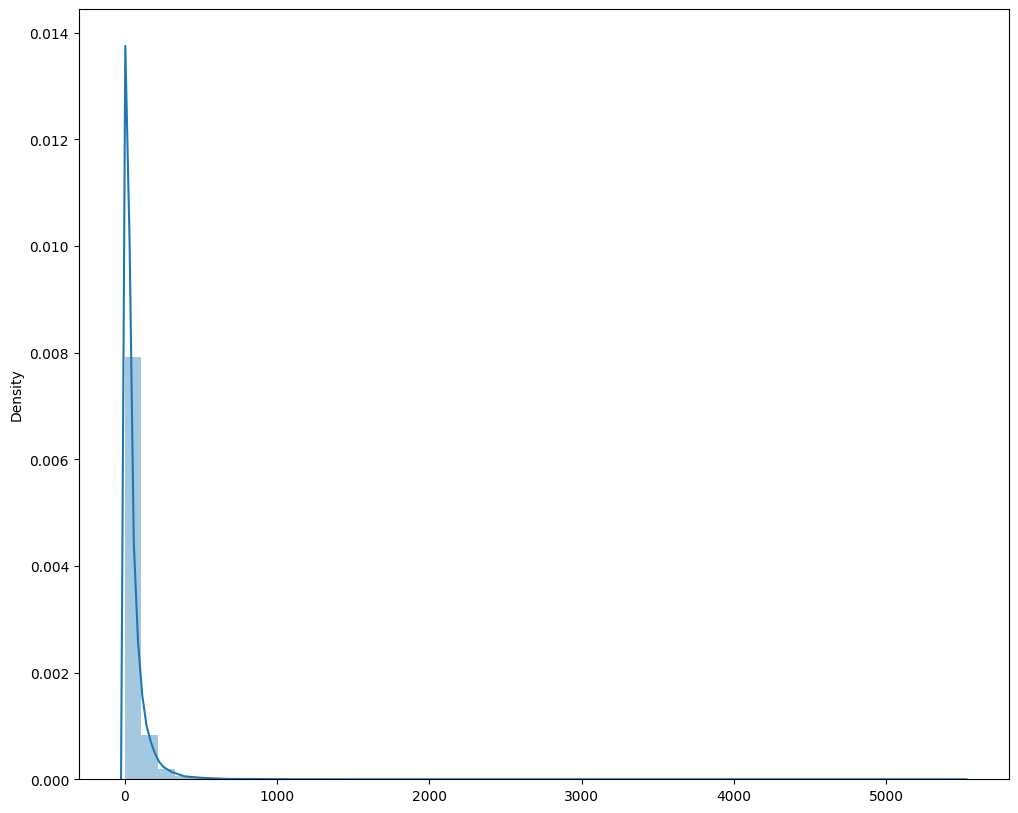

In [ ]:
plt.figure(figsize=(12,10))
sns.distplot(train_text_length)
plt.show()

After this, We would continue with the pre-processing of the text. Therefore, We would be vectorizing the texts, convert each one on a sequence of intengers. This we the objetive to build a machine learning model. For accomplish this we'll use Tokenizer

In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [ ]:
tokenizer

 Next, we count the frecuency of each word and visualize it:

In [ ]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(
    by='count',ascending=False)

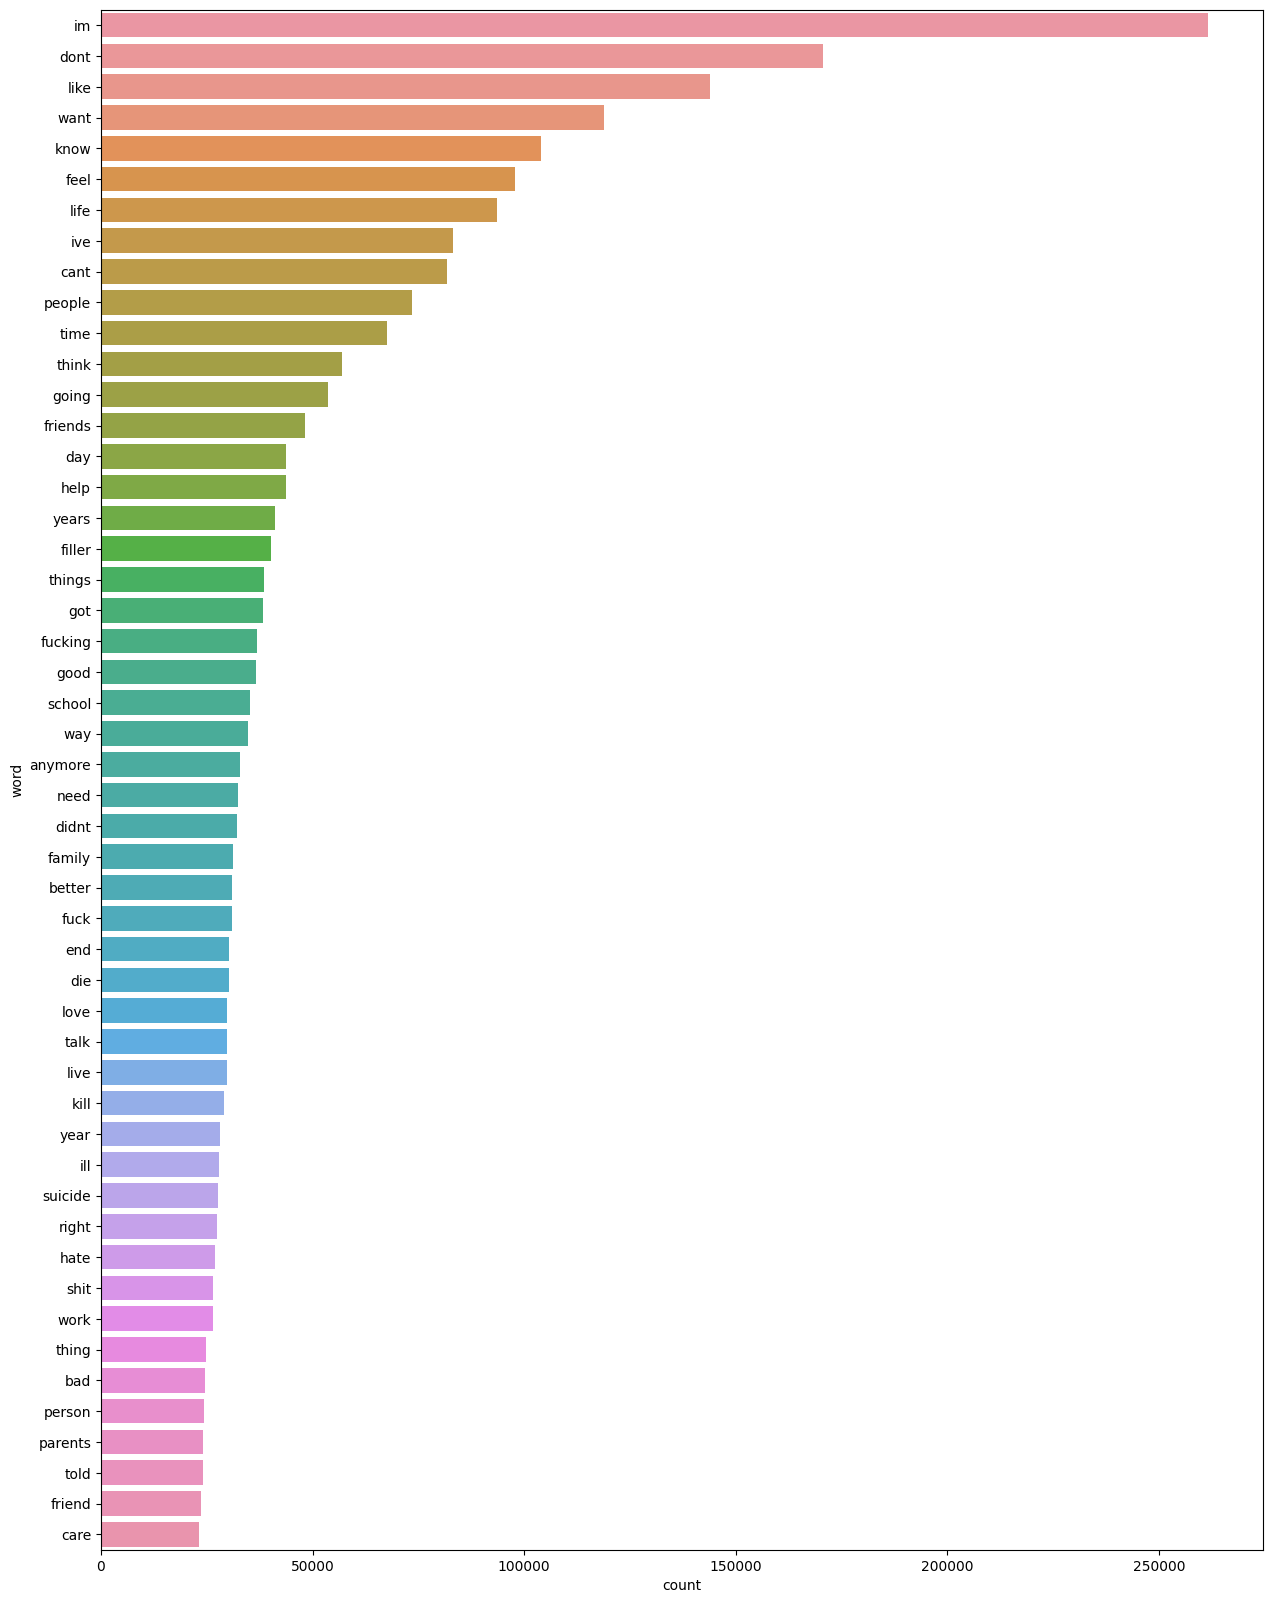

In [ ]:
plt.figure(figsize=(15,20))
sns.barplot(x='count',y='word',data=word_freq.iloc[:50])
plt.show()

Another kind of visualization whith the more present words within the different reddit statements ( with a max a 400 word and only taken a subset):

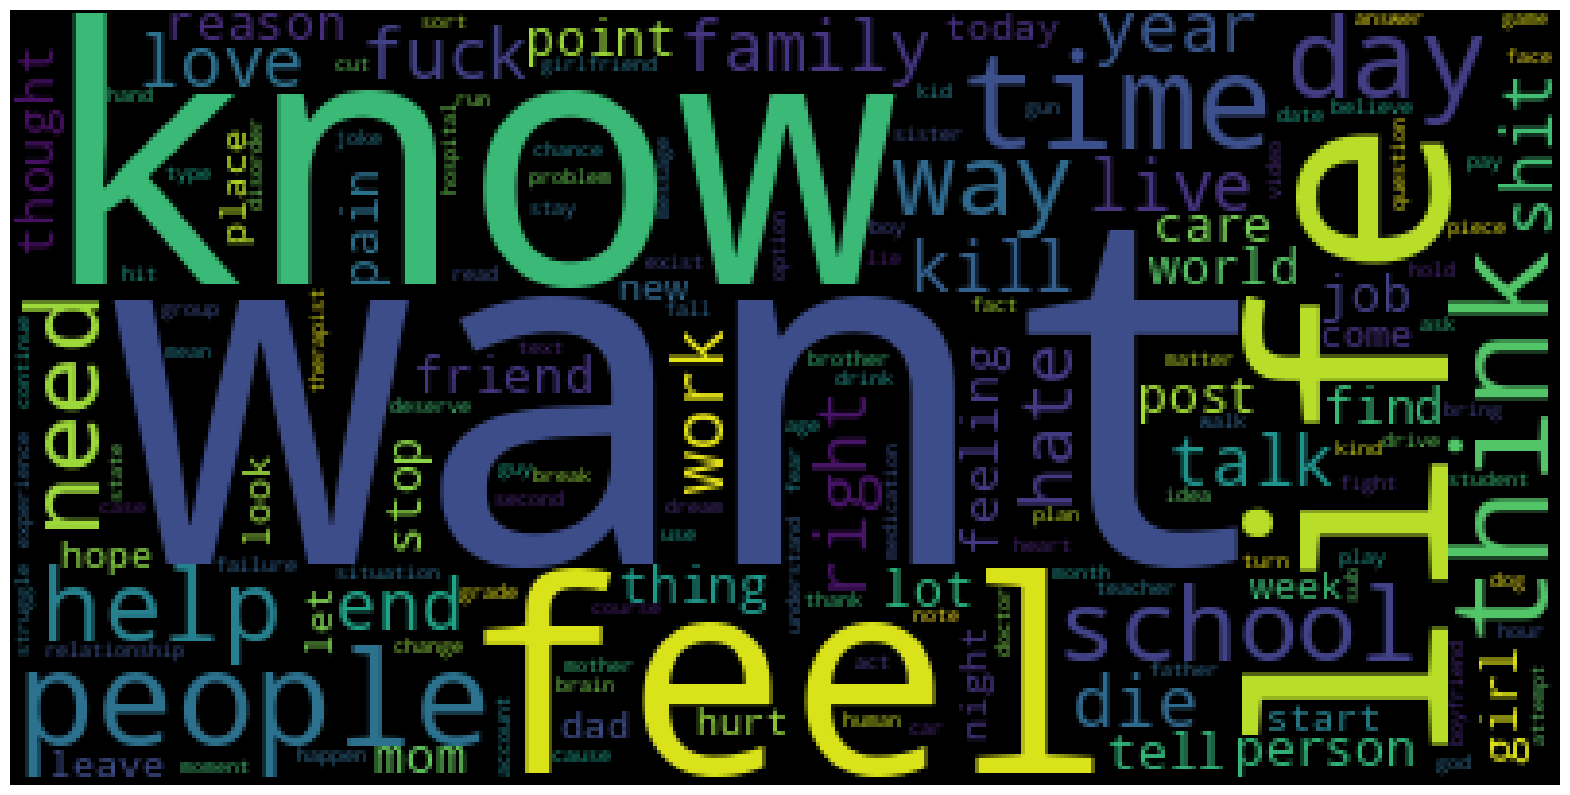

In [ ]:
feature_names=word_freq['word'].values
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[0:3000] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

###Model

Adjust data

Now, It's time to make procces the data with the objetive use it on the the train of a machine learning model. Using the tokenizer already created, we'll replace each word with the corresponding index set by the tokenizer. Then, we will have sequence of integers insted of strings:

In [ ]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)

In [ ]:
train_text_seq[0]

[436, 3985, 1618, 1272, 129, 5574, 176, 3027, 3]

After, It's neccesary to apply padding due that some sequences are longer than others (the commets on reddit have different lenght):

In [ ]:
train_text_pad=pad_sequences(train_text_seq,maxlen=50)

In [ ]:
train_text_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,  436, 3985, 1618,
       1272,  129, 5574,  176, 3027,    3], dtype=int32)

Apply the same for test dataset:

In [ ]:
test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [ ]:
test_text_pad[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,   590,  2970, 28775,  1711, 26001,   486,
         147,   118,  2387,   757,   357,    68,   415,  4690,  8712,
        1415,    99,   364,   735, 87407], dtype=int32)

In [ ]:
test_text_pad[0].shape

(50,)

Set the labels of the objective variable:

In [ ]:
lbl_target=LabelEncoder()
train_y=lbl_target.fit_transform(train_data['class'])
test_y=lbl_target.transform(test_data['class'])

In [ ]:
train_y

array([0, 0, 1, ..., 0, 1, 1])

####model development

We are dealing with a problem that requires manage sequetial data. For this reason, the model that I select is Recurrent Neural Network, specifically Long Short-Term Memory (LSTM) which are designed to address this kind of challenge. On addition, I add and 'embedding layer' which transforms the tokens, already creted, into vector of real numbers using a vector space taht have into account the relations of differnte words:

In [ ]:
words=len(tokenizer.word_index)

In [ ]:
words

271868

In [ ]:
model=Sequential()
model.add(Input(shape=(50,)))
model.add(Embedding(words+1, 300))
model.add(LSTM(20,return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
early_stop=EarlyStopping(patience=5) # stop when the accuracy no improve for  5 epoch
reducelr=ReduceLROnPlateau(patience=3) # adjust learning rate when the accuracy doesn't improve for three epoch

In [ ]:
ml_model=model.fit(train_text_pad,train_y,validation_data=(test_text_pad,test_y),
            epochs=5,batch_size=256,callbacks=[early_stop,reducelr])

Epoch 1/5
726/726 [==============================] - 1005s 1s/step - loss: 0.5269 - accuracy: 0.7556 - val_loss: 0.3921 - val_accuracy: 0.8328 - lr: 0.1000
Epoch 2/5
726/726 [==============================] - 1019s 1s/step - loss: 0.3263 - accuracy: 0.8656 - val_loss: 0.2611 - val_accuracy: 0.8980 - lr: 0.1000
Epoch 3/5
726/726 [==============================] - 1018s 1s/step - loss: 0.2550 - accuracy: 0.8991 - val_loss: 0.3346 - val_accuracy: 0.8618 - lr: 0.1000
Epoch 4/5
726/726 [==============================] - 1035s 1s/step - loss: 0.2323 - accuracy: 0.9093 - val_loss: 0.2653 - val_accuracy: 0.8949 - lr: 0.1000
Epoch 5/5
726/726 [==============================] - 1134s 2s/step - loss: 0.2170 - accuracy: 0.9159 - val_loss: 0.2616 - val_accuracy: 0.8942 - lr: 0.1000


####Validation:

With the objective to validate the performance of the model, It's neccesary create a set of graphs and obtain different metrics which allow a complete understanding of it. Therefore, in first place we create a visualization showing the accuracy of the train and test datasert in each apoch of the training process:

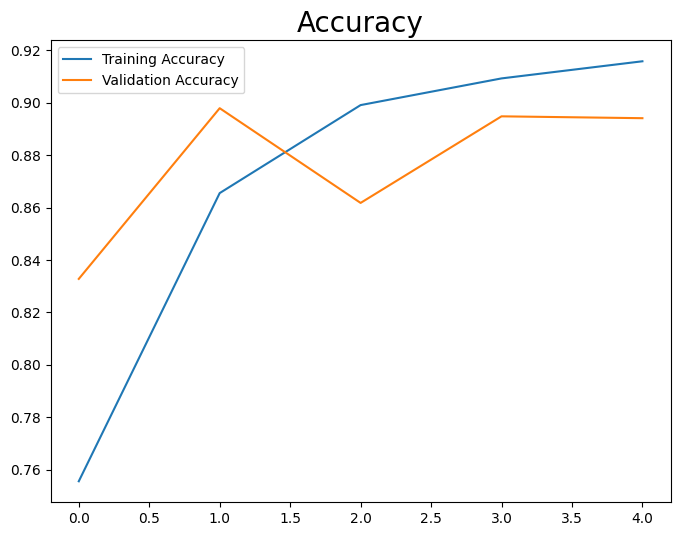

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(ml_model.history['accuracy'],label='Training Accuracy')
plt.plot(ml_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy',fontdict={'size':20})
plt.legend()
plt.show()

Now, we create a graph of the loss in each epoch:

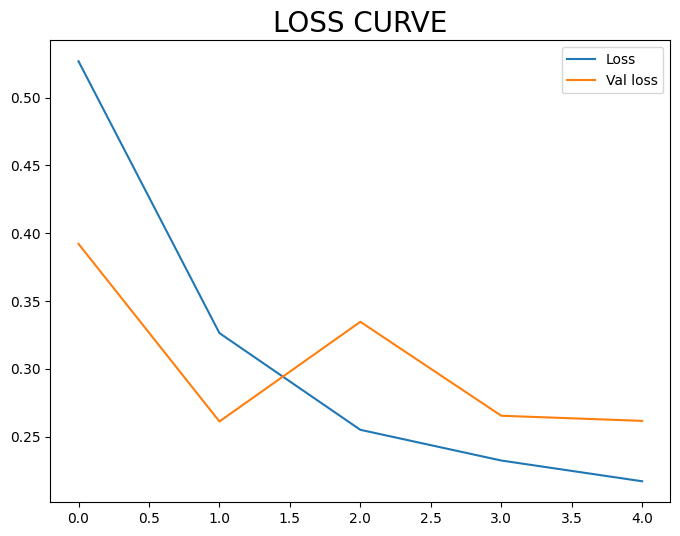

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(ml_model.history['loss'],label='Loss')
plt.plot(ml_model.history['val_loss'],label='Val loss')
plt.title('LOSS CURVE',fontdict={'size':20})
plt.legend()
plt.show()

Next, qe calculate metrics that are important for understand the performance of the model:

In [ ]:
y_predict = model.predict(test_text_pad)

1451/1451 [==============================] - 24s 16ms/step


In [ ]:
y_predict

array([[4.8914086e-03],
       [4.3214434e-03],
       [4.2818423e-02],
       ...,
       [9.6143997e-01],
       [4.9666813e-01],
       [8.8485121e-04]], dtype=float32)

In [ ]:
threshold = 0.5
y_predict = (y_predict > threshold).astype(int)

In [ ]:
y_predict

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [ ]:
print(classification_report(test_y,y_predict))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90     23209
           1       0.96      0.82      0.89     23206

    accuracy                           0.89     46415
   macro avg       0.90      0.89      0.89     46415
weighted avg       0.90      0.89      0.89     46415



Confusion matrix on the test data:

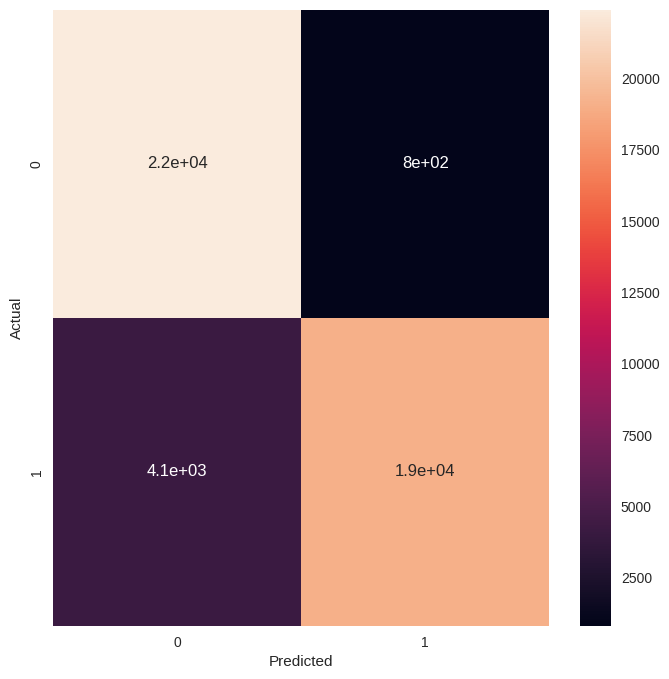

In [ ]:
confusion=confusion_matrix(test_y,y_predict)
plt.figure(figsize=(8,8))
sns.heatmap(confusion,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Finally, we obtain the ROC_AUC curve:

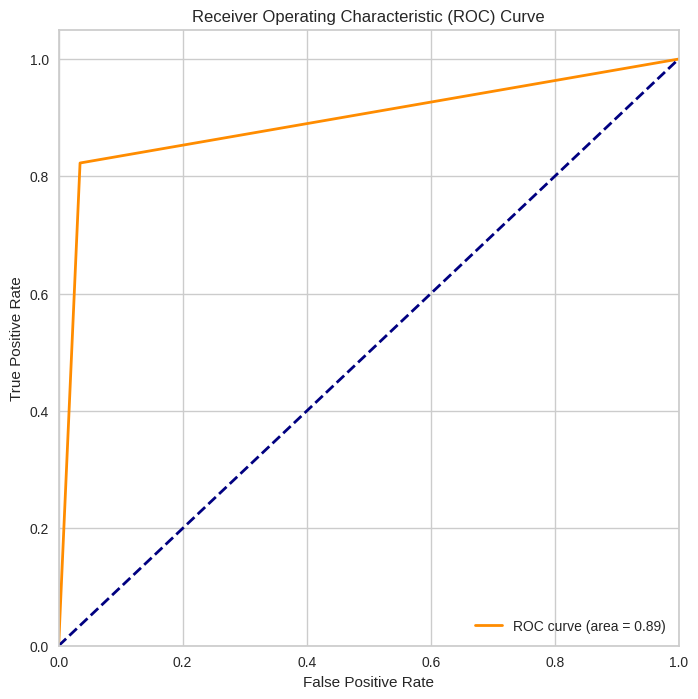

In [ ]:
fpr, tpr, _ = roc_curve(test_y, y_predict)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Due to the information of the metrics, we can rely on the model which is capable of predict if a comment contains suicidal thoughts/behavior, with an accuracy of 89% and a ROC curve of the same value, this last measure shows that the model identifies each class correctly.   